In [10]:
import geopandas as gpd
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import cbsodata

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from pysal.model import spreg

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", message=".*NumbaDeprecationWarning.*")

# Load files

In [3]:
# load calculated vgvi for the entire NED file
vgvi = gpd.read_file('ned_vgvi.gpkg')
vgvi = vgvi.drop(columns=['id']) # drop duplicated index 
vgvi.head()

VGVI                      geometry
0  0.090724  POINT (45505.651 389195.137)
1  0.086609  POINT (45511.796 389262.109)
2  0.014458  POINT (64760.609 396333.239)
3  0.000000  POINT (64771.736 384438.722)
4  0.000000  POINT (64721.616 384437.883)

In [4]:
# obtain data on socio-economic indicators from cbs 

# gdf_cbs = pd.DataFrame(cbsodata.get_data('85039NED')) # obtain the data from cbs 2021
# gdf_cbs_20 = pd.DataFrame(cbsodata.get_data('84799NED')) # obtain the data from cbs 2021
# gdf_cbs.to_csv('data_collection/gdf_cbs.csv', index=False) # save the data locally
# gdf_cbs_20.to_csv('data_collection/gdf_cbs_20.csv', index=False) # save the data locally

gdf_cbs = pd.read_csv('data_collection/gdf_cbs.csv')
gdf_cbs_20 = pd.read_csv('data_collection/gdf_cbs_20.csv')

In [16]:
# load burt and wijk files with polygons for later merge 
gdf_buurt = gpd.read_file("data_collection/income_data/WijkBuurtkaart_2018_v3/buurt_2018_v3.shp")
gdf_wijk = gpd.read_file("data_collection/income_data/WijkBuurtkaart_2018_v3/wijk_2018_v3.shp")

# Data preprocessing

In [ ]:
# gdf_cbs.to_csv('cbs_data.csv', index=False)

In [5]:
rename_dict = {'SoortRegio_2': 'type',
               'k_0Tot15Jaar_8': 'age_0_15',
                'k_15Tot25Jaar_9': 'age_15_25',
                'k_25Tot45Jaar_10': 'age_25_45',
                'k_45Tot65Jaar_11': 'age_45_65',
                'k_65JaarOfOuder_12': 'age_65_older',
               'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
                'Mannen_6': 'population',
               'GeboorteRelatief_25': 'birth_rate_1000',
               'SterfteRelatief_27': 'mortality_1000',
               'GemiddeldeHuishoudensgrootte_32': 'avg_household_size',
               'Bevolkingsdichtheid_33': 'population_density',
               'GemiddeldeWOZWaardeVanWoningen_35': 'avg_values_home',
               'GemiddeldElektriciteitsverbruikTotaal_47': 'avg_eletricity_cons',
               'GemiddeldAardgasverbruikTotaal_55': 'avg_nat_gas_cons',
               'Huurwoning_61': 'rental_home',
               'EigenWoning_62': 'non_rental_home',
               'OpleidingsniveauLaag_64': 'educ_low',
               'OpleidingsniveauMiddelbaar_65': 'educ_secondary',
               'OpleidingsniveauHoog_66': 'educ_high',
               'BedrijfsvestigingenTotaal_91': 'companies_total',
               'PersonenautoSPerHuishouden_103': 'cars_per_household',
               'MateVanStedelijkheid_116': 'degree_urbanity',
               'AantalInkomensontvangers_70': 'income_recipients_total',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant',
               'GemiddeldInkomenPerInkomensontvanger_71': 'avg_income_recipient',  
               'GemGestandaardiseerdInkomenVanHuish_75': 'avg_income_stand_household_1000'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# # rename and filter columns
gdf_cbs_filtered = gdf_cbs.copy()
gdf_cbs_filtered = gdf_cbs_filtered.rename(columns=rename_dict)  # rename specified columns
gdf_cbs_filtered = gdf_cbs_filtered[list(columns_to_keep) + list(rename_dict.values())]

# # calculate average age based on weighted category by the midpoint
age_columns = ['age_0_15', 'age_15_25', 'age_25_45', 'age_45_65', 'age_65_older']
gdf_cbs_filtered.drop('population', axis=1, inplace=True) # delete current population column, the given column had errors only 8686536 people for the Netherlands 
gdf_cbs_filtered['population'] = gdf_cbs_filtered[age_columns].sum(axis=1) # add new column based on age groups

weights = [7.5, 20, 35, 55, 75] # weights based on midpoints 
gdf_cbs_filtered['average_age'] = gdf_cbs_filtered[age_columns].mul(weights).sum(axis=1) / gdf_cbs_filtered[age_columns].sum(axis=1)

# drop old columns
gdf_cbs_filtered = gdf_cbs_filtered.drop(columns=age_columns)

# create a single column of percentage of people with higher education 
gdf_cbs_filtered['higher_educ'] = (gdf_cbs_filtered['educ_high'] / gdf_cbs_filtered['population']) * 100
gdf_cbs_filtered = gdf_cbs_filtered.drop(['educ_low', 'educ_secondary', 'educ_high'], axis=1)

gdf_cbs_filtered.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  companies_total  cars_per_household  \
0               2810.0  ...          2104540                 1.1   
1               3160.0  ...             2915                 1.3   
2               3030.0  ...              360                 1.3   
3               2970.0  ...              330                 1.3   
4               4620.0  ...               30                 1.5   

   degree_urbanity  income_recipients_total  avg_income_inhabitant  \
0              2.0                 13946000                   29.2   
1              5.0                    20900                   29.7   
2              5.0                     3000                   30.9   
3              5.0                     2800                   30.2   
4              5.0                      100                    NaN   

   avg_income_recipient  avg_income_stand_household_1000  population  \
0                  35.8                             33.5    17475415   
1                  35.3                             35.1       25399   
2                  37.1                              NaN        3595   
3                  36.4                              NaN        3425   
4                   NaN                              NaN         150   

   average_age  higher_educ  
0    42.326804    24.123376  
1    46.980098    23.504862  
2    46.279555    24.200278  
3    46.102190    23.941606  
4    51.916667    33.333333  

[5 rows x 23 columns]

In [6]:
# chech number of missing values per column 
missing_values = gdf_cbs_filtered.isnull().sum()
print(missing_values)

WijkenEnBuurten                        0
type                                   0
Gemeentenaam                           0
code                                   0
birth_rate_1000                        0
mortality_1000                         0
avg_household_size                   373
population_density                   716
avg_values_home                     1989
avg_eletricity_cons                  941
avg_nat_gas_cons                    1011
rental_home                         2828
non_rental_home                     1285
companies_total                        0
cars_per_household                  3197
degree_urbanity                       75
income_recipients_total                0
avg_income_inhabitant              13637
avg_income_recipient               14326
avg_income_stand_household_1000    15864
population                             0
average_age                          483
higher_educ                         2162
dtype: int64


<Axes: >

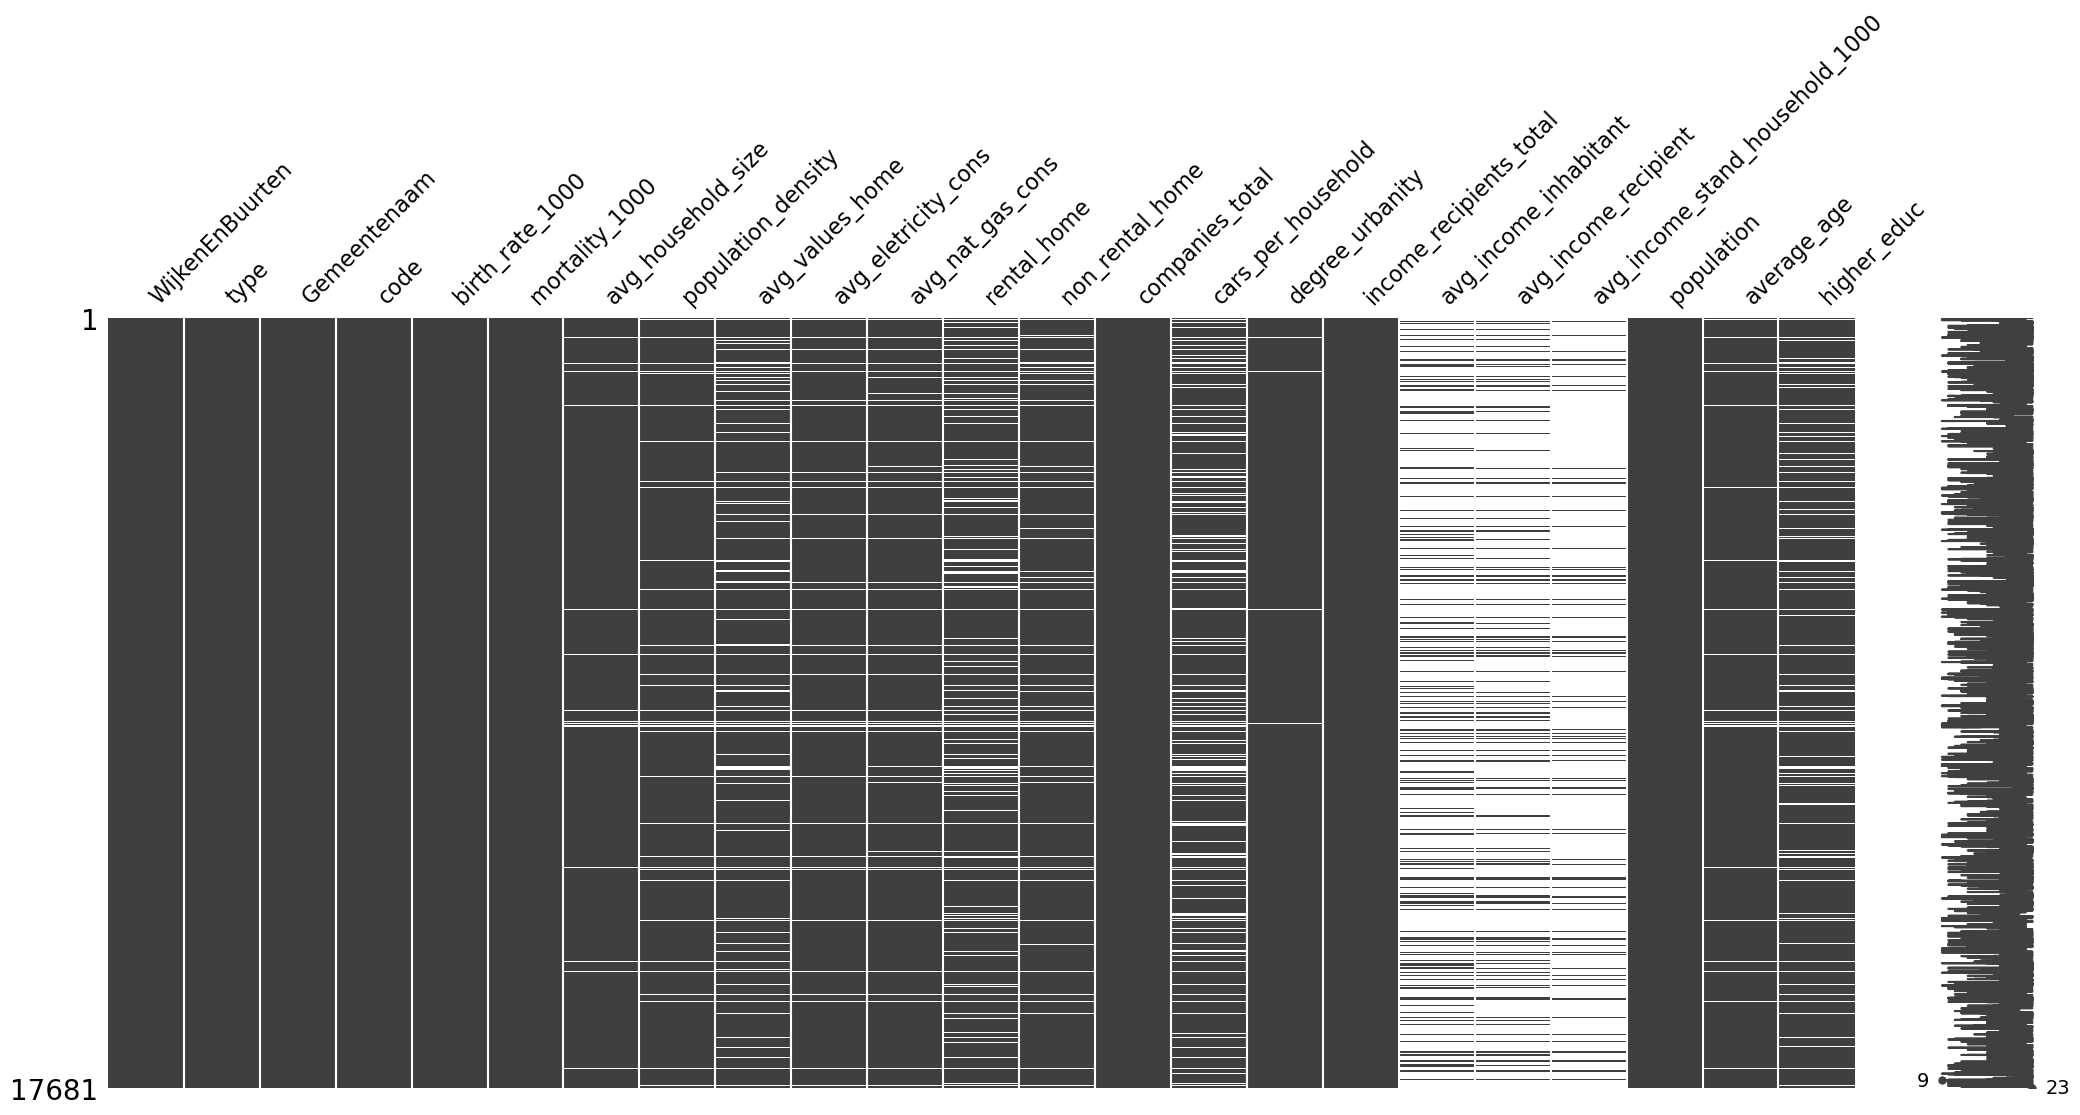

In [7]:
# check missingness
msno.matrix(gdf_cbs_filtered)

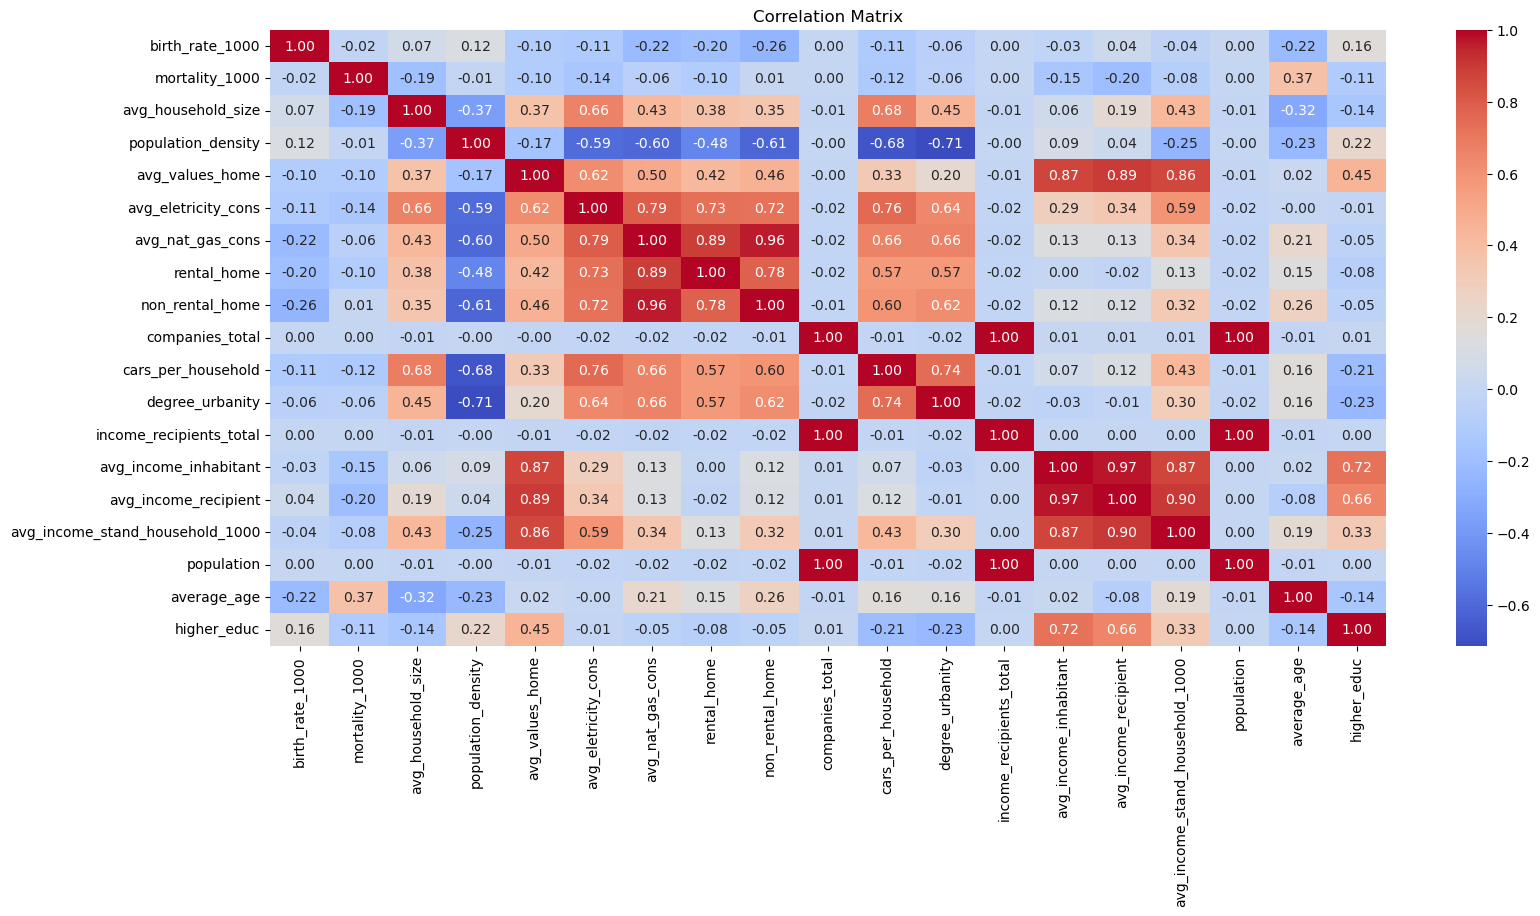

In [11]:
# calculate the correlation matrix
numeric_columns = gdf_cbs_filtered.select_dtypes(include=[np.number]).columns
correlation_matrix = gdf_cbs_filtered[numeric_columns].corr()

# create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
# the majority of income data missing
gdf_cbs_filtered['avg_income_inhabitant'].isna().sum()
gdf_cbs_filtered['avg_income_inhabitant']

0        29.2
1        29.7
2        30.9
3        30.2
4         NaN
         ... 
17676    27.2
17677     NaN
17678     NaN
17679     NaN
17680     NaN
Name: avg_income_inhabitant, Length: 17681, dtype: float64

In [13]:
# preprocess the cbs '20 data 
rename_dict = {'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# # rename and filter columns
gdf_cbs_filtered_20 = gdf_cbs_20.copy()
gdf_cbs_filtered_20 = gdf_cbs_filtered_20.rename(columns=rename_dict)  # rename specified columns
gdf_cbs_filtered_20 = gdf_cbs_filtered_20[list(columns_to_keep) + list(rename_dict.values())]

# the majority of income data missing, but available in cbs '20 data hence imputed below
gdf_cbs_filtered['avg_income_inhabitant'] = gdf_cbs_filtered['avg_income_inhabitant'].mask(gdf_cbs_filtered['avg_income_inhabitant'].isnull())  
gdf_cbs_filtered['avg_income_inhabitant'] = gdf_cbs_filtered['avg_income_inhabitant'].combine_first(gdf_cbs_filtered['code'].map(gdf_cbs_filtered_20.set_index('code')['avg_income_inhabitant']))
gdf_cbs_filtered.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  companies_total  cars_per_household  \
0               2810.0  ...          2104540                 1.1   
1               3160.0  ...             2915                 1.3   
2               3030.0  ...              360                 1.3   
3               2970.0  ...              330                 1.3   
4               4620.0  ...               30                 1.5   

   degree_urbanity  income_recipients_total  avg_income_inhabitant  \
0              2.0                 13946000                   29.2   
1              5.0                    20900                   29.7   
2              5.0                     3000                   30.9   
3              5.0                     2800                   30.2   
4              5.0                      100                   43.1   

   avg_income_recipient  avg_income_stand_household_1000  population  \
0                  35.8                             33.5    17475415   
1                  35.3                             35.1       25399   
2                  37.1                              NaN        3595   
3                  36.4                              NaN        3425   
4                   NaN                              NaN         150   

   average_age  higher_educ  
0    42.326804    24.123376  
1    46.980098    23.504862  
2    46.279555    24.200278  
3    46.102190    23.941606  
4    51.916667    33.333333  

[5 rows x 23 columns]

In [33]:
# check the missigness after imputation
gdf_cbs_filtered['avg_income_inhabitant'].isna().sum()

3266

In [17]:
# filter  the buurt data with polygons to be merged onto cbs 
gdf_buurt_filtered = gdf_buurt.copy()
gdf_buurt_filtered = gdf_buurt_filtered[["BU_CODE", "BU_NAAM", "WK_CODE", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

# filter the wijk data with polygons to be merged onto cbs 
gdf_wijk_filtered = gdf_wijk.copy()
gdf_wijk_filtered = gdf_wijk_filtered[["WK_CODE", "WK_NAAM", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

gdf_buurt_filtered

BU_CODE                                    BU_NAAM   WK_CODE  \
0      BU09989999                                 Buitenland  WK099899   
1      BU00109998                                        NaN  WK001099   
2      BU00349997                                        NaN  WK003499   
3      BU00509997                                        NaN  WK005099   
4      BU00569997                                        NaN  WK005699   
...           ...                                        ...       ...   
13399  BU19550205                 Verspreide huizen De Heegh  WK195502   
13400  BU19550206              Verspreide huizen Greffelkamp  WK195502   
13401  BU19550207  Verspreide huizen De Hogenend en Oud-Dijk  WK195502   
13402  BU19550208               Verspreide huizen Nieuw-Dijk  WK195502   
13403  BU19550209                     Verspreide huizen Loil  WK195502   

      GM_CODE      GM_NAAM                                           geometry  
0      GM0998   Buitenland  MULTIPOLYGON (((122416.410 383920.760, 122395....  
1      GM0010     Delfzijl  MULTIPOLYGON (((268674.309 592382.331, 268667....  
2      GM0034       Almere  MULTIPOLYGON (((150213.998 479503.726, 150087....  
3      GM0050     Zeewolde  MULTIPOLYGON (((170588.413 486792.192, 170570....  
4      GM0056     Zuidhorn  MULTIPOLYGON (((214960.238 595344.114, 215030....  
...       ...          ...                                                ...  
13399  GM1955  Montferland  POLYGON ((206718.500 440320.094, 206724.094 44...  
13400  GM1955  Montferland  POLYGON ((204831.875 442520.751, 204833.020 44...  
13401  GM1955  Montferland  POLYGON ((205483.000 439755.688, 205473.297 43...  
13402  GM1955  Montferland  POLYGON ((209695.907 440263.853, 209698.974 44...  
13403  GM1955  Montferland  POLYGON ((207290.435 443026.560, 207290.455 44...  

[13404 rows x 6 columns]

## Merge data

In [34]:
# merge burt data w/ polygons with cbs data and aggregate them on buurt level 
merged_df = pd.merge(gdf_buurt_filtered, gdf_cbs_filtered, left_on='BU_CODE', right_on='code', how='left')
buurt_cbs_joined = gpd.GeoDataFrame(merged_df)

joined_data = gpd.sjoin(buurt_cbs_joined, vgvi, how='left', op='contains')
vgvi_by_bu = joined_data.groupby('BU_CODE')['VGVI'].mean().reset_index()

buurt_cbs_joined = buurt_cbs_joined.merge(vgvi_by_bu, on='BU_CODE', how='left')

C:\Users\Ondrej\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# save the file
buurt_cbs_joined.to_file('data_collection/cleaned_data/buurt_cbs_joined.gpkg', driver="GPKG")

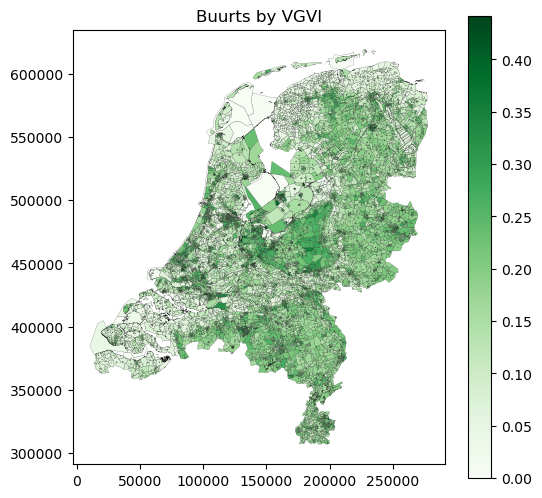

In [20]:
buurt_cbs_joined_filtered = buurt_cbs_joined[~buurt_cbs_joined['VGVI'].isnull()]
buurt_cbs_joined_filtered = buurt_cbs_joined_filtered.to_crs(epsg=28992)
fig, ax = plt.subplots(figsize=(6, 6))
buurt_cbs_joined_filtered.plot(column='VGVI', cmap='Greens', linewidth=0.1, edgecolor='black', legend=True, ax=ax)
plt.title('Buurts by VGVI')

plt.show()

## Wijk level

In [108]:
joined_data = gpd.sjoin(gdf_wijk_filtered, vgvi, how='left', op='contains')
vgvi_by_wijk = joined_data.groupby('WK_CODE')['VGVI'].mean().reset_index()

wijk_cbs_joined = gdf_wijk_filtered.merge(vgvi_by_wijk, on='WK_CODE', how='left')
wijk_cbs_joined

C:\Users\Ondrej\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


WK_CODE                WK_NAAM GM_CODE           GM_NAAM  \
0     WK099899             Buitenland  GM0998        Buitenland   
1     WK001099                    NaN  GM0010          Delfzijl   
2     WK003499                    NaN  GM0034            Almere   
3     WK005099                    NaN  GM0050          Zeewolde   
4     WK005699                    NaN  GM0056          Zuidhorn   
...        ...                    ...     ...               ...   
3169  WK195220              Zuidbroek  GM1952  Midden-Groningen   
3170  WK195221                 Meeden  GM1952  Midden-Groningen   
3171  WK195500  Wijk 00 's-Heerenberg  GM1955       Montferland   
3172  WK195501         Wijk 01 Brakel  GM1955       Montferland   
3173  WK195502          Wijk 02 Didam  GM1955       Montferland   

                                               geometry      VGVI  
0     MULTIPOLYGON (((122416.410 383920.760, 122395....  0.146787  
1     MULTIPOLYGON (((268674.309 592382.331, 268667....       NaN  
2     MULTIPOLYGON (((150213.998 479503.726, 150087....  0.257910  
3     MULTIPOLYGON (((170588.413 486792.192, 170570....  0.008146  
4     MULTIPOLYGON (((214960.238 595344.114, 215030....       NaN  
...                                                 ...       ...  
3169  POLYGON ((254730.907 578403.951, 254737.414 57...  0.151430  
3170  POLYGON ((256409.951 576591.951, 256416.541 57...  0.138032  
3171  POLYGON ((214858.094 434220.594, 214892.297 43...  0.143882  
3172  POLYGON ((209458.692 438018.685, 209461.472 43...  0.149558  
3173  POLYGON ((205237.879 442710.445, 205237.895 44...  0.158382  

[3174 rows x 6 columns]

C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


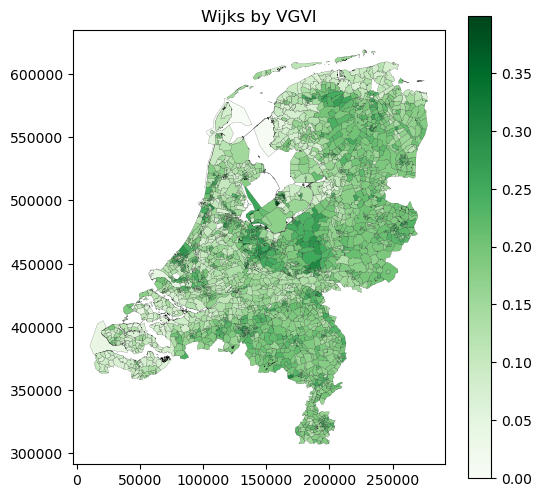

In [49]:
wijk_cbs_joined_filtered = wijk_cbs_joined[~buurt_cbs_joined['VGVI'].isnull()]
wijk_cbs_joined_filtered = wijk_cbs_joined_filtered.to_crs(epsg=28992)
fig, ax = plt.subplots(figsize=(6, 6))
wijk_cbs_joined_filtered.plot(column='VGVI', cmap='Greens', linewidth=0.1, edgecolor='black', legend=True, ax=ax)
plt.title('Wijks by VGVI')

plt.show()

# Spatial autocorrelation

In [110]:
buurt_cbs_joined.columns

Index(['BU_CODE', 'BU_NAAM', 'WK_CODE', 'GM_CODE', 'GM_NAAM', 'geometry',
       'WijkenEnBuurten', 'type', 'Gemeentenaam', 'code', 'birth_rate_1000',
       'mortality_1000', 'avg_household_size', 'population_density',
       'avg_values_home', 'avg_eletricity_cons', 'avg_nat_gas_cons',
       'rental_home', 'non_rental_home', 'companies_total',
       'cars_per_household', 'degree_urbanity', 'income_recipients_total',
       'avg_income_inhabitant', 'avg_income_recipient',
       'avg_income_stand_household_1000', 'population', 'average_age',
       'higher_educ', 'VGVI'],
      dtype='object')

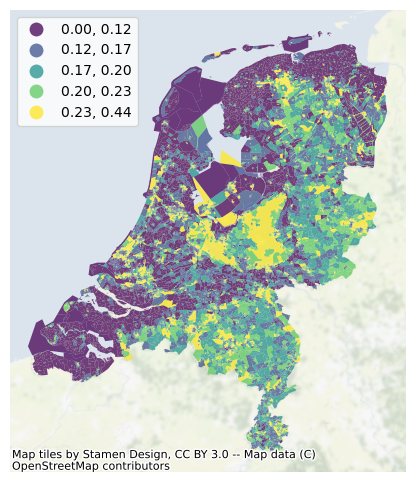

In [203]:
variable_names = [
    "VGVI",
    "geometry"
]

db = buurt_cbs_joined[variable_names].copy()
db.dropna(inplace=True) # remove rows with empty fields

f, ax = plt.subplots(1, figsize=(6, 6))
db.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Stamen.TerrainBackground,
    attribution=None,
    alpha = 0.35
)
ax.set_axis_off()

In [206]:
from libpysal import weights

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

db["VGVI_lag"] = weights.spatial_lag.lag_spatial(
    w, db["VGVI"]
)

C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


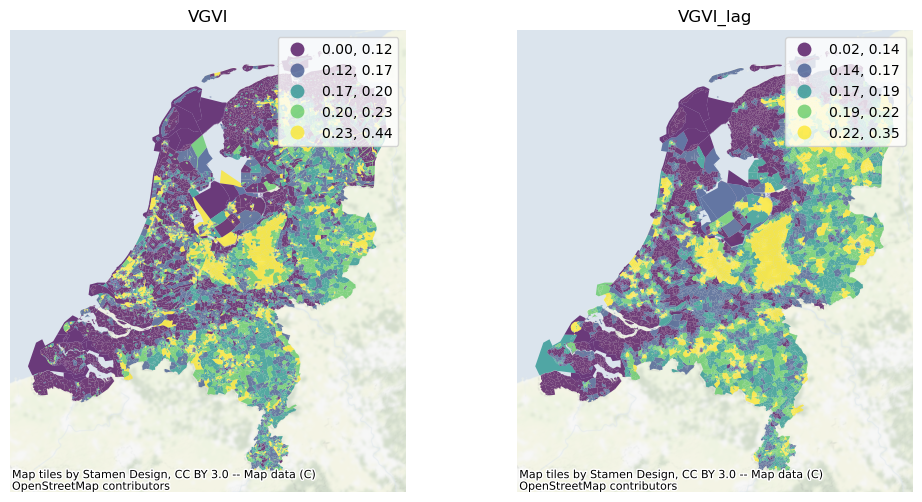

In [207]:
# create a plot for both VGVI and its lag model
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("VGVI")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Stamen.TerrainBackground,
    alpha=0.35
)

db.plot(
    column="VGVI_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("VGVI_lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Stamen.TerrainBackground,
    alpha = 0.35
)


plt.show()

## Moran Statistic

In [208]:
db["VGVI_std"] = db["VGVI"] - db["VGVI"].mean()
db["VGVI_lag_std"] = weights.lag_spatial(
    w, db["VGVI_std"]
)

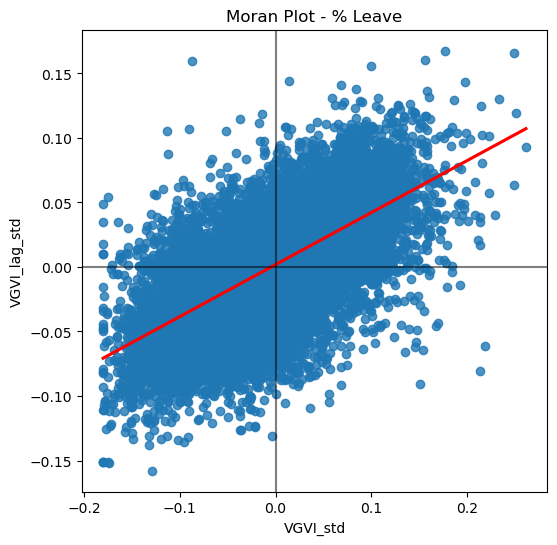

In [213]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="VGVI_std",
    y="VGVI_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - GVI")
plt.show()

In [224]:
w.transform = "R"
moran = esda.moran.Moran(db["VGVI"], w)
print("Moran's I:", moran.I)
print("p-value (p-sim):", moran.p_sim)

Moran's I: 0.40281794000674037
p-value (p-sim): 0.001


## LISA

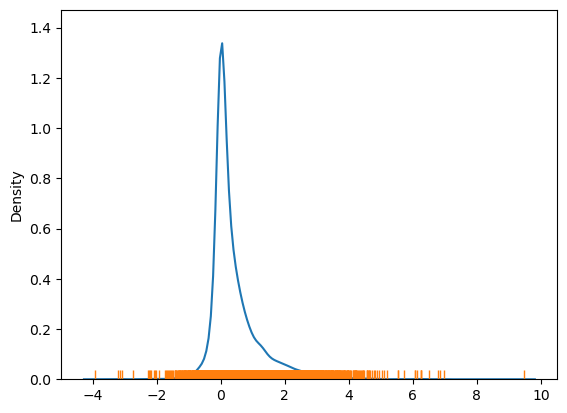

In [227]:
lisa = esda.moran.Moran_Local(db["VGVI"], w)
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax)

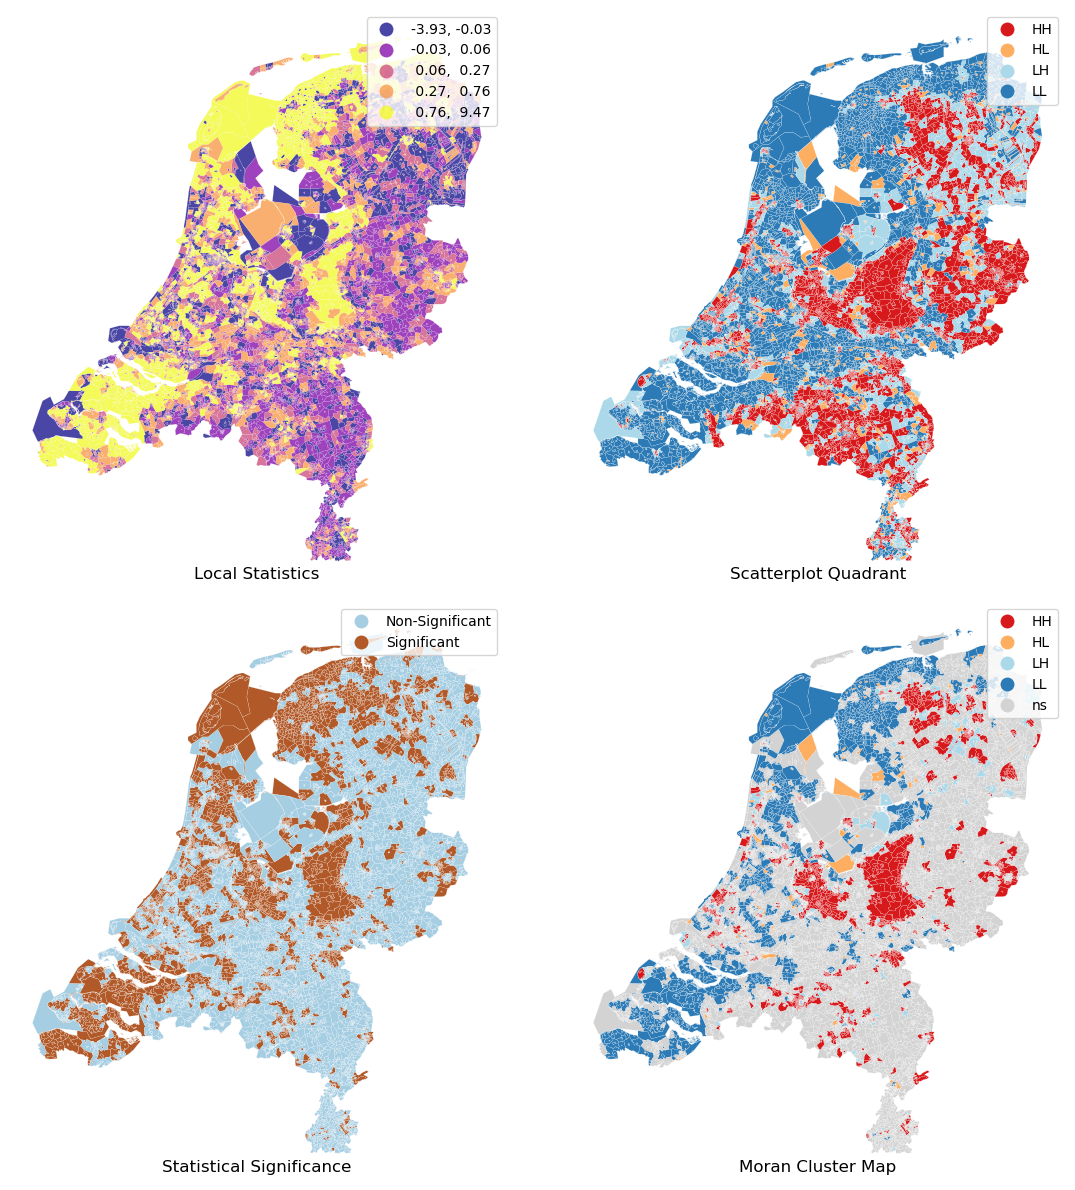

In [228]:
from splot import esda as esdaplot

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

## GI* algorithm

In [229]:
# Gi
go_i = esda.getisord.G_Local(db["VGVI"], w)
go_i_star = esda.getisord.G_Local(db["VGVI"], w, star=True)

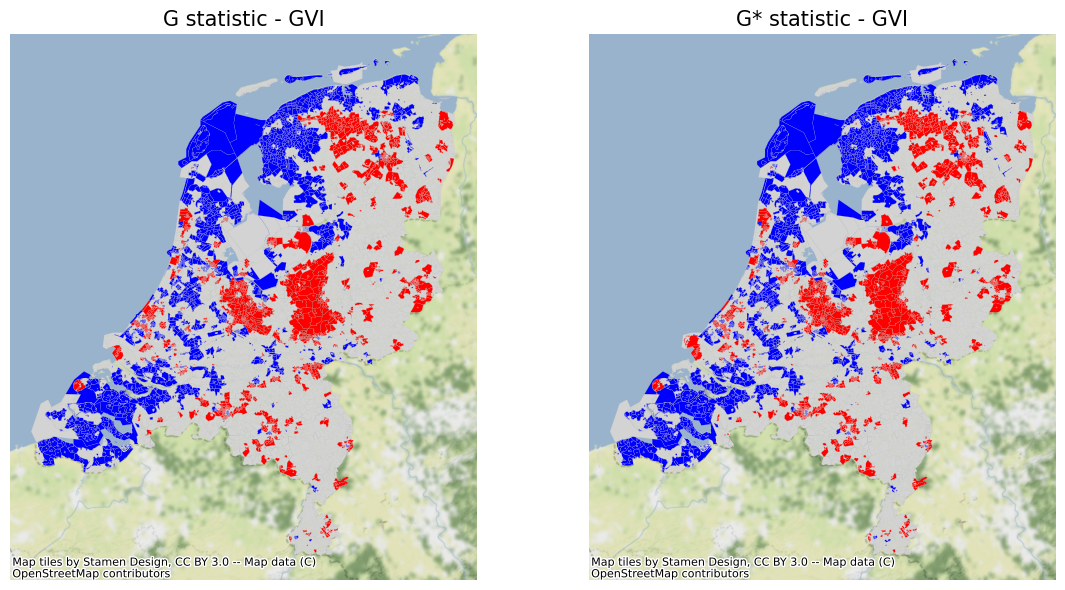

In [230]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic - GVI", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

# GWR 

In [22]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

In [23]:
# load cleaned dataset
buurt_cbs_joined = gpd.read_file('data_collection/cleaned_data/buurt_cbs_joined.gpkg')

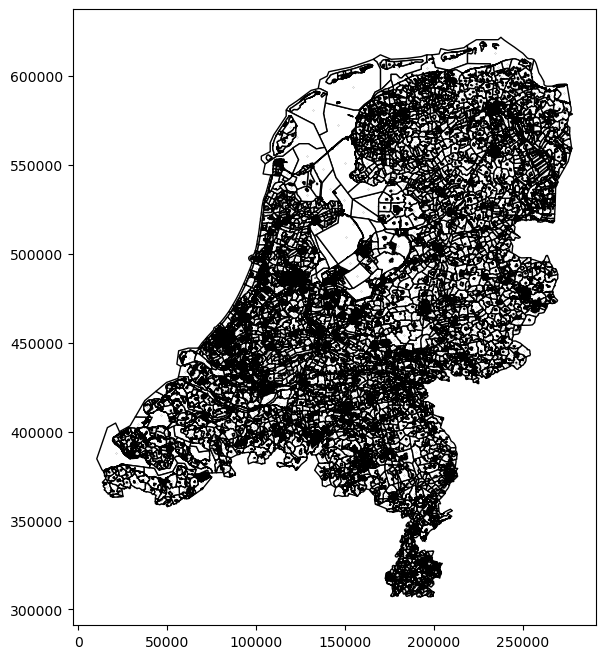

In [25]:
fig, ax = plt.subplots(figsize = (8, 8))
buurt_cbs_joined.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
buurt_cbs_joined.centroid.plot(ax = ax, c = 'black', markersize=1/100)
plt.show()

In [26]:
buurt_cbs_joined.columns

Index(['BU_CODE', 'BU_NAAM', 'WK_CODE', 'GM_CODE', 'GM_NAAM',
       'WijkenEnBuurten', 'type', 'Gemeentenaam', 'code', 'birth_rate_1000',
       'mortality_1000', 'avg_household_size', 'population_density',
       'avg_values_home', 'avg_eletricity_cons', 'avg_nat_gas_cons',
       'rental_home', 'non_rental_home', 'companies_total',
       'cars_per_household', 'degree_urbanity', 'income_recipients_total',
       'avg_income_inhabitant', 'avg_income_recipient',
       'avg_income_stand_household_1000', 'population', 'average_age',
       'higher_educ', 'VGVI', 'geometry'],
      dtype='object')

In [110]:
# perform OLS first to get an idea of the data
# Define the variable names to filter
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "degree_urbanity",
    "geometry",
    "VGVI"
]


filtered_gdf = buurt_cbs_joined.copy()
filtered_gdf = filtered_gdf[variable_names]
filtered_gdf.dropna(inplace=True)
filtered_gdf.reset_index(drop=True, inplace=True)
filtered_gdf.head()

avg_income_inhabitant  higher_educ  average_age  degree_urbanity  \
0                   22.1    41.509434    31.958935              1.0   
1                   22.7    45.709828    32.583853              1.0   
2                   21.5    44.124700    33.603118              1.0   
3                   24.8    45.481050    34.569971              1.0   
4                   26.9    45.535714    35.232143              1.0   

                                            geometry      VGVI  
0  POLYGON ((233142.230 582047.170, 233182.170 58...  0.097535  
1  POLYGON ((234188.240 581967.600, 234269.187 58...  0.133514  
2  POLYGON ((233749.554 582381.330, 233749.036 58...  0.154336  
3  POLYGON ((233128.282 582044.117, 233142.230 58...  0.133627  
4  POLYGON ((234047.500 582938.000, 234098.513 58...  0.141828

In [82]:
# log transform variables 
variable_names = ['avg_income_inhabitant', 'higher_educ', 'average_age']
filtered_gdf[variable_names] = filtered_gdf[variable_names].apply(np.log)

print("Negative or zero values in transformed variables:")
print((filtered_gdf[variable_names] <= 0).sum())

minimal_constant = 0.00001
filtered_gdf['higher_educ'] = np.where(filtered_gdf['higher_educ'] == float('-inf'), minimal_constant, filtered_gdf['higher_educ'])

print("Negative or zero values in transformed variables after adding constant:")
print((filtered_gdf[variable_names] <= 0).sum())

In [89]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "degree_urbanity"
]

db = filtered_gdf.copy()
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["VGVI"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="VGVI",
    # Independent variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        VGVI                Number of Observations:        9348
Mean dependent var  :      0.1856                Number of Variables   :           5
S.D. dependent var  :      0.0594                Degrees of Freedom    :        9343
R-squared           :      0.0801
Adjusted R-squared  :      0.0797
Sum squared residual:      30.293                F-statistic           :    203.4182
Sigma-square        :       0.003                Prob(F-statistic)     :  1.452e-167
S.E. of regression  :       0.057                Log likelihood        :   13527.078
Sigma-square ML     :       0.003                Akaike info criterion :  -27044.155
S.E of regression ML:      0.0569                Schwarz criterion     :  -27008.441

-----------------------------------------------------------------------------

## GWR - Fixed kernel

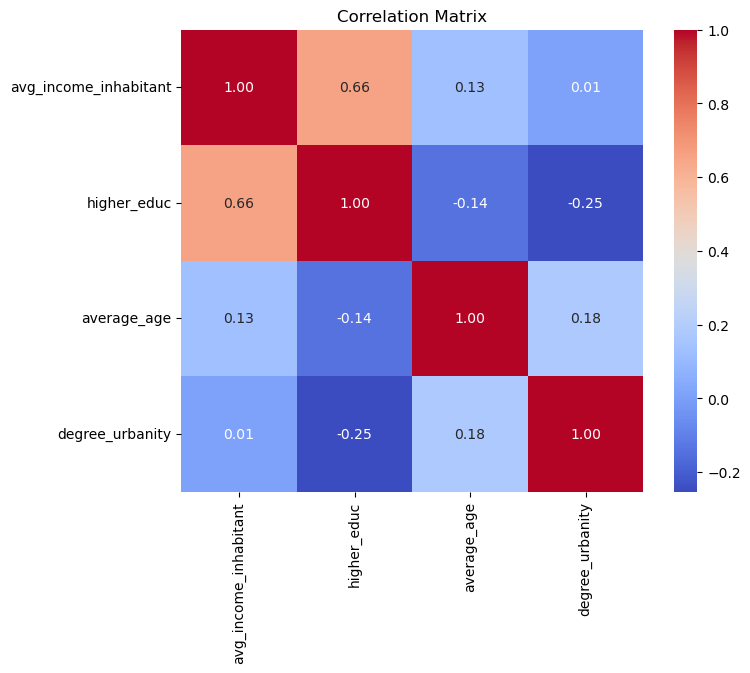

In [114]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "degree_urbanity"
]

correlation_matrix = filtered_gdf[variable_names].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [108]:
small_constant = 0.001
data_matrix = filtered_gdf[variable_names].values
data_matrix += np.eye(data_matrix.shape[1]) * small_constant

ValueError: operands could not be broadcast together with shapes (9348,6) (6,6) (9348,6) 

In [100]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "degree_urbanity"
]

g_y = filtered_gdf['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = filtered_gdf[variable_names].values.astype(float)

u = filtered_gdf['geometry'].centroid.x
v = filtered_gdf['geometry'].centroid.y

g_X = (g_X - g_X.mean(axis = 0)) / g_X.std(axis = 0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis = 0)) / g_y.std(axis = 0)

g_coords = list(zip(u, v))

In [101]:
bw = Sel_BW(g_coords, g_y, g_X).search(criterion='AICc')
gwr_results = GWR(g_coords, g_y, g_X, bw).fit()
gwr_results.summary()

C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.18818e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.56762e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.2018e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.88975e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.37112e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\Ondrej\.conda\envs\ssml\lib

LinAlgError: Matrix is singular.

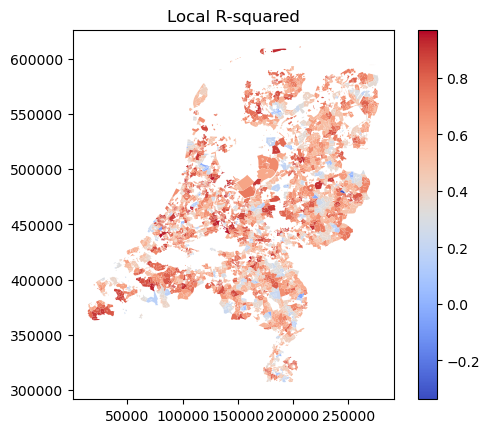

In [23]:
# Access the local R-squared values
local_r2 = gwr_results.localR2

# Visualize the local R-squared values on a map
filtered_gdf['local_r2'] = local_r2
filtered_gdf.plot(column='local_r2', cmap='coolwarm', legend=True)
plt.title('Local R-squared')
plt.show()

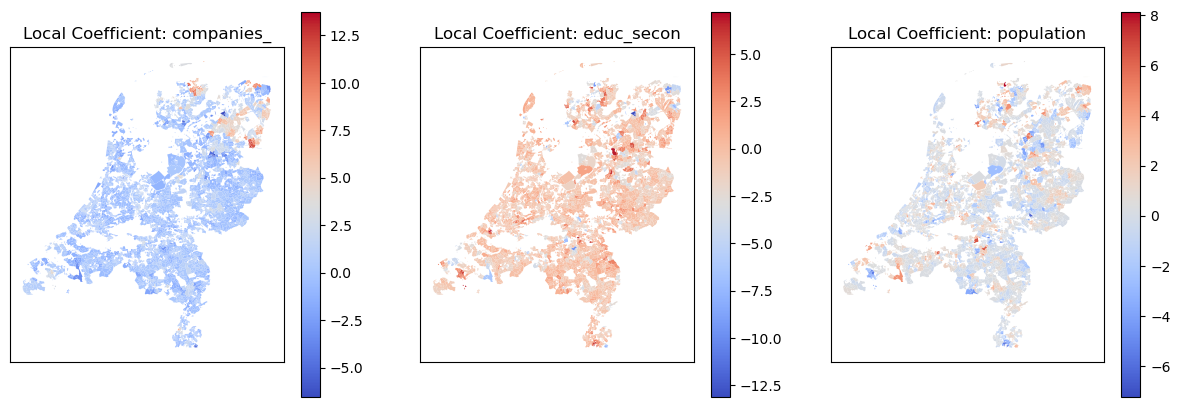

In [27]:
gwr_results = GWR(g_coords, g_y, g_X, 20).fit()

# Visualize the local coefficients of each variable on separate maps
variable_names = [
    "companies_", 
    "educ_secon", 
    "population"
] # Update with the names of your variables
fig, axs = plt.subplots(1, len(variable_names), figsize=(15, 5))

for i, coef_variable in enumerate(variable_names):
    # Plot the local coefficient values on a map
    filtered_gdf['local_coefficients'] = local_coefficients[:, i]
    filtered_gdf.plot(column='local_coefficients', cmap='coolwarm', legend=True, ax=axs[i])
    axs[i].set_title('Local Coefficient: {}'.format(coef_variable))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)

plt.show()

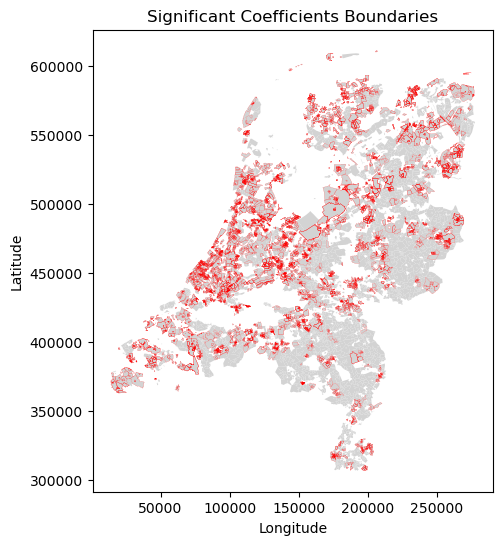

In [45]:
import matplotlib.pyplot as plt

# Get the t-values from GWR results
t_values = gwr_results.tvalues

# Check if the coefficients for the independent variable are statistically significant
is_significant = (t_values < -1.96) | (t_values > 1.96)  # Significance level at 95%

# Plot the significant coefficients with boundaries and no fill
fig, ax = plt.subplots(figsize=(6, 6))
filtered_gdf.plot(color='lightgray', ax=ax)  
filtered_gdf[is_significant].boundary.plot(color='red', linewidth=1/10, ax=ax)  # Plot only boundaries of significant coefficients

# Plot the non-significant coefficients with no boundaries and no fill
filtered_gdf[~is_significant].plot(facecolor='none', edgecolor='none', ax=ax)

# Add labels and title
ax.set_title('Significant Coefficients Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


# MGWR

In [9]:
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [10]:
# mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
# mgwr_bw = mgwr_selector.search()

In [11]:
# mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_bw).fit()

In [ ]:
print(mgwr_results.ENP_j)
print(mgwr_results.adj_alpha_j[:,1])


In [116]:
from pysal.model import spreg

In [137]:
buurt_cbs_joined['avg_nat_gas_cons']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
13399    1780.0
13400    2070.0
13401    1330.0
13402    2070.0
13403    2140.0
Name: avg_nat_gas_cons, Length: 13404, dtype: float64

In [96]:
variable_names = [
    "companies_total", 
    "cars_per_household",  
    "degree_urbanity",  
    "avg_eletricity_cons",
    "avg_nat_gas_cons",
    "educ_high",
    "educ_secondary",
    "educ_low",
    "population_density",
    "avg_values_home"
]

variable_names.append("VGVI") 

filtered_gdf = buurt_cbs_joined.dropna(subset=variable_names)
# filtered_gdf = filtered_gdf.drop_duplicates() # remove duplicated columns
filtered_gdf = filtered_gdf.loc[:, ~filtered_gdf.columns.duplicated()]
filtered_gdf = filtered_gdf[variable_names].dropna()
filtered_gdf

companies_total  cars_per_household  degree_urbanity  \
150              975.0                 0.2              1.0   
151             1620.0                 0.2              1.0   
152              590.0                 0.2              1.0   
153              295.0                 0.3              1.0   
155              890.0                 0.3              1.0   
...                ...                 ...              ...   
13399             30.0                 0.6              4.0   
13400             75.0                 1.7              5.0   
13401            210.0                 1.5              4.0   
13402            160.0                 1.5              5.0   
13403             95.0                 1.5              5.0   

       avg_eletricity_cons  avg_nat_gas_cons  educ_high  educ_secondary  \
150                 2170.0            1250.0     1870.0          2150.0   
151                 2100.0            1170.0     2930.0          3070.0   
152                 1890.0             980.0     1840.0          1780.0   
153                 1970.0            1100.0      780.0           770.0   
155                 1990.0            1020.0     2550.0          2320.0   
...                    ...               ...        ...             ...   
13399               6190.0            1780.0       70.0            50.0   
13400               4340.0            2070.0       70.0           130.0   
13401               3260.0            1330.0      310.0           500.0   
13402               4430.0            2070.0      140.0           320.0   
13403               4300.0            2140.0      130.0           260.0   

       educ_low  population_density  avg_values_home      VGVI  
150       300.0             12192.0            222.0  0.097535  
151       360.0             11651.0            225.0  0.133514  
152       280.0             15441.0            191.0  0.154336  
153        80.0             17200.0            226.0  0.133627  
155       340.0             13019.0            224.0  0.141828  
...         ...                 ...              ...       ...  
13399      40.0               260.0            419.0  0.129021  
13400     160.0                69.0            342.0  0.148288  
13401     190.0               267.0            275.0  0.166025  
13402     190.0                96.0            345.0  0.166284  
13403     150.0                90.0            348.0  0.130628  

[8877 rows x 11 columns]

In [93]:
print(m1.summary)

NameError: name 'm1' is not defined

# Inequality using GINI index